## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

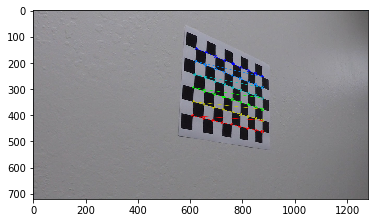

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mtimage

%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = mtimage.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)

# Load one of the calibration image to get the image shape
calibration_img_path='../camera_cal/calibration1.jpg'
calibration_img = mtimage.imread(calibration_img_path)

# Calibrate the camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
    objpoints, imgpoints, (calibration_img.shape[1], calibration_img.shape[0]), None, None)

## Apply a distortion correction to raw images

In [2]:
def undistort(distorted_image, mtx, dist):
    return cv2.undistort(distorted_image, mtx, dist, None, mtx)

def demo_undistort(image_path, mtx, dist):
    original = mtimage.imread(image_path)
    undistorted = undistort(original, mtx, dist)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    
    ax1.imshow(original)
    ax1.set_title("Original Image", fontsize=20)
    
    ax2.imshow(undistorted)
    ax2.set_title("Undistorted Image", fontsize=20)
    
    plt.show()

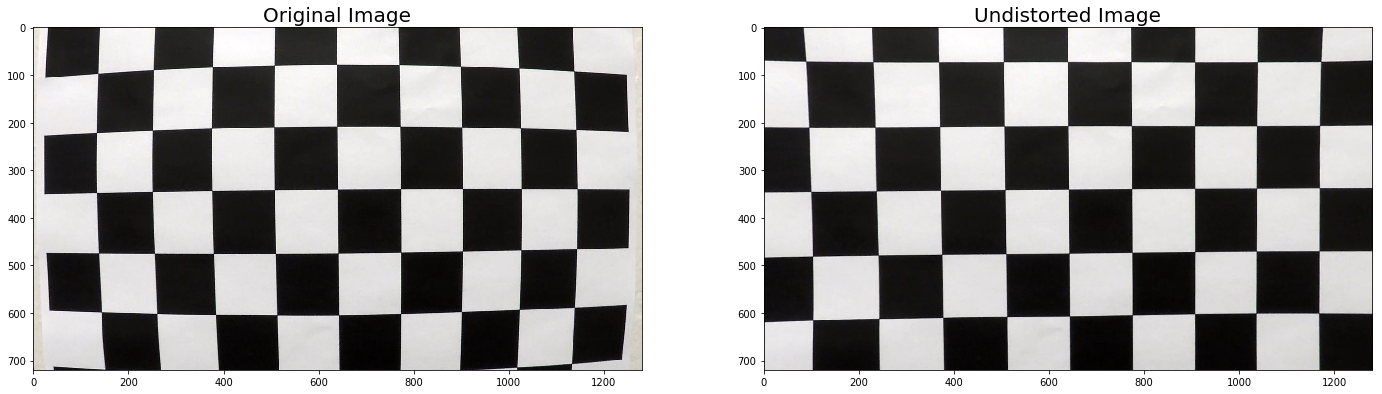

In [3]:
demo_undistort('../camera_cal/calibration1.jpg', mtx, dist)

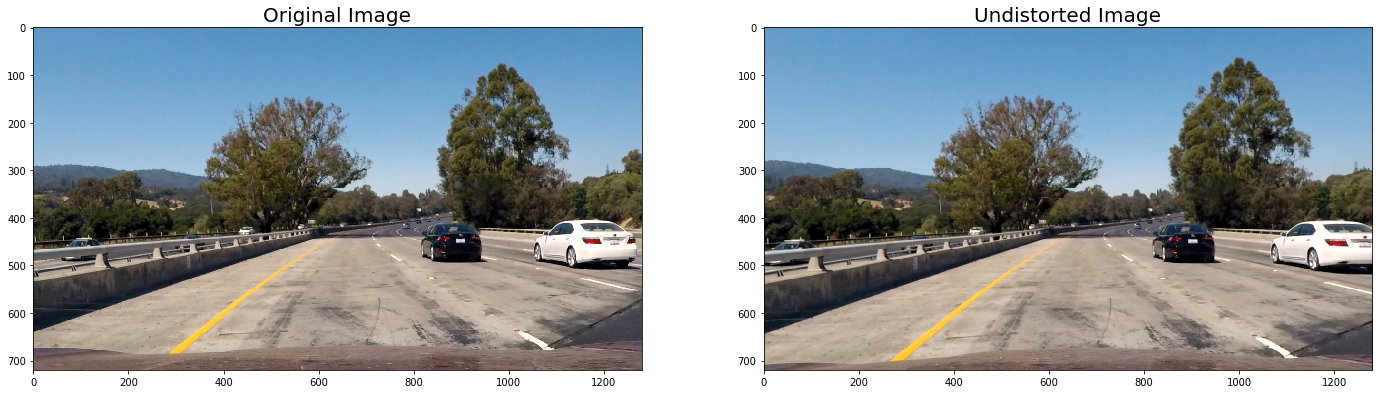

In [4]:
demo_undistort('../test_images/test1.jpg', mtx, dist)

## Use color transforms, gradients, etc., to create a thresholded binary image.

In [5]:
image = mtimage.imread('../test_images/test6.jpg')

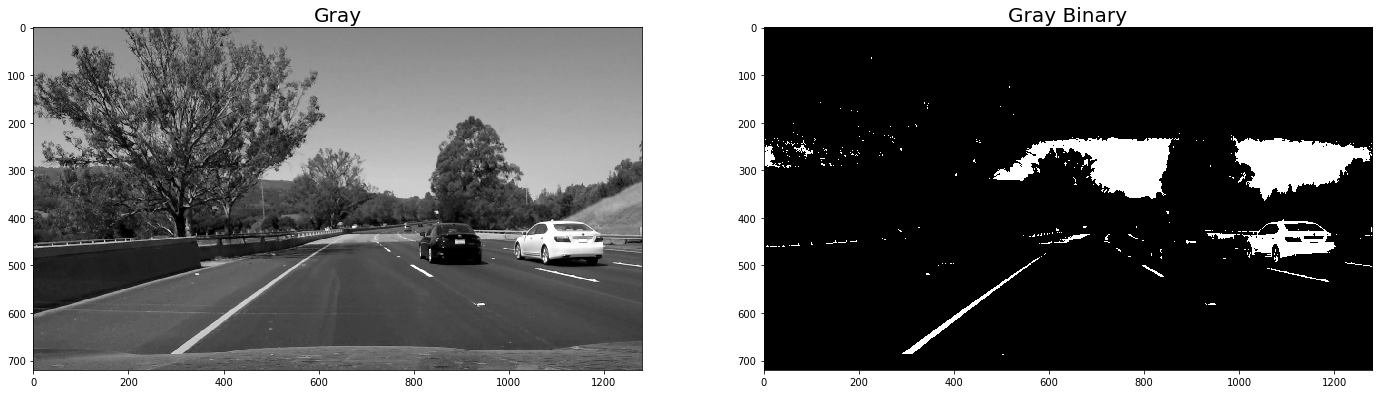

In [6]:
def demo_gray_binary(image, thresh=(180, 255)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    binary = np.zeros_like(gray)
    binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1
    
    f, axis = plt.subplots(1, 2, figsize=(24, 9))
    axis = axis.ravel()
    
    for i, (title, image) in zip(range(0, 2), zip(['Gray', 'Gray Binary'], [gray, binary])):
        axis[i].imshow(image, cmap='gray')
        axis[i].set_title(title, fontsize=20)
    plt.show()    

demo_gray_binary(image)

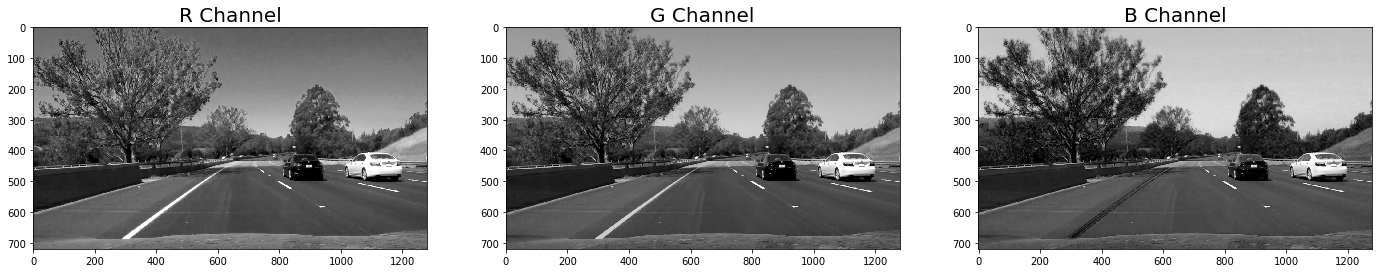

In [7]:
def demo_rgb(image):
    R = image[:,:,0]
    G = image[:,:,1]
    B = image[:,:,2]

    f, axis = plt.subplots(1, 3, figsize=(24, 9))
    axis = axis.ravel()
    
    for i, (title, image) in zip(range(0, 3), zip(['R Channel', 'G Channel', 'B Channel'], [R, G, B])):
        axis[i].imshow(image, cmap='gray')
        axis[i].set_title(title, fontsize=20)
    plt.show()
    
demo_rgb(image)

The R channel does a reasonable job of highlighting the lines, and you can apply a similar threshold to find lane-line pixels:

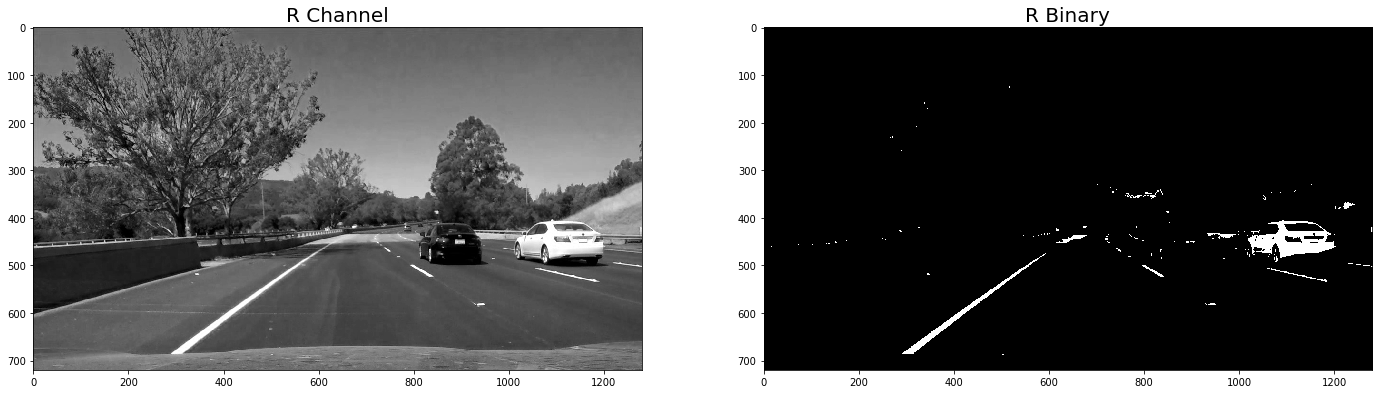

In [8]:
def demo_r_binary(image, thresh = (200, 255)):
    R = image[:,:,0]
    
    binary = np.zeros_like(R)
    binary[(R > thresh[0]) & (R <= thresh[1])] = 1
    
    f, axis = plt.subplots(1, 2, figsize=(24, 9))
    axis = axis.ravel()
    
    for i, (title, image) in zip(range(0, 2), zip(['R Channel', 'R Binary'], [R, binary])):
        axis[i].imshow(image, cmap='gray')
        axis[i].set_title(title, fontsize=20)
    plt.show()
    
demo_r_binary(image)

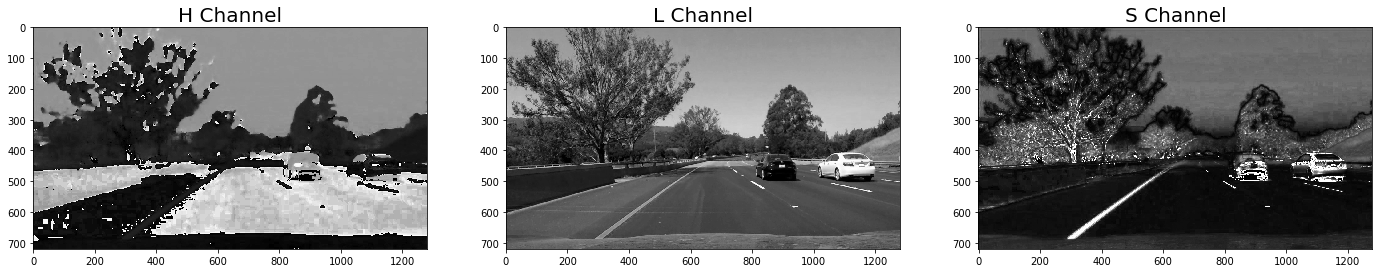

In [9]:
def demo_hls(image):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]

    f, axis = plt.subplots(1, 3, figsize=(24, 9))
    axis = axis.ravel()
    
    for i, (title, image) in zip(range(0, 3), zip(['H Channel', 'L Channel', 'S Channel'], [H, L, S])):
        axis[i].imshow(image, cmap='gray')
        axis[i].set_title(title, fontsize=20)
    plt.show()
    
demo_hls(image)

The S channel picks up the lines well, so let's try applying a threshold there:

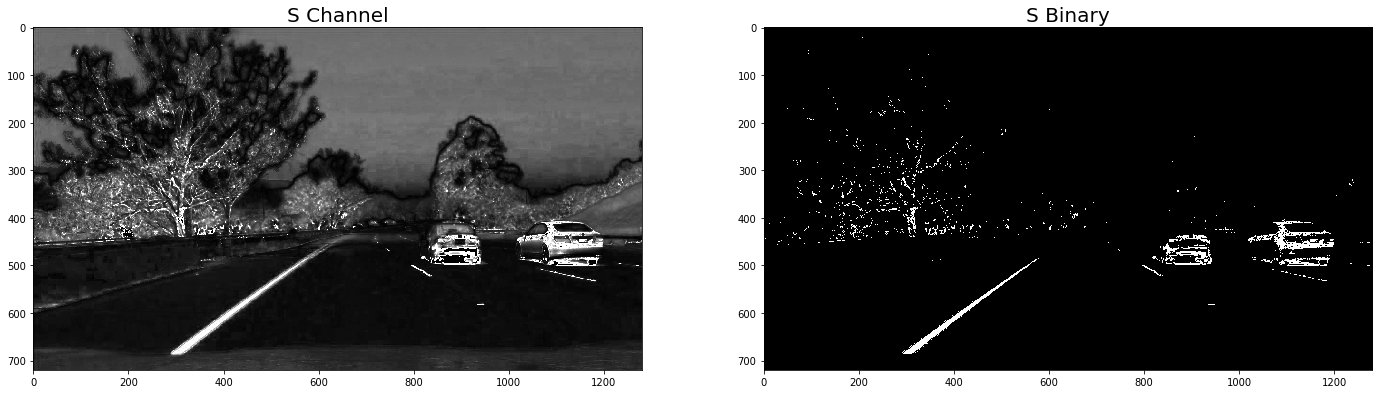

In [10]:
def demo_s_binary(image, thresh = (200, 255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    
    f, axis = plt.subplots(1, 2, figsize=(24, 9))
    axis = axis.ravel()
    
    for i, (title, image) in zip(range(0, 2), zip(['S Channel', 'S Binary'], [S, binary])):
        axis[i].imshow(image, cmap='gray')
        axis[i].set_title(title, fontsize=20)
    plt.show()
    
demo_s_binary(image)

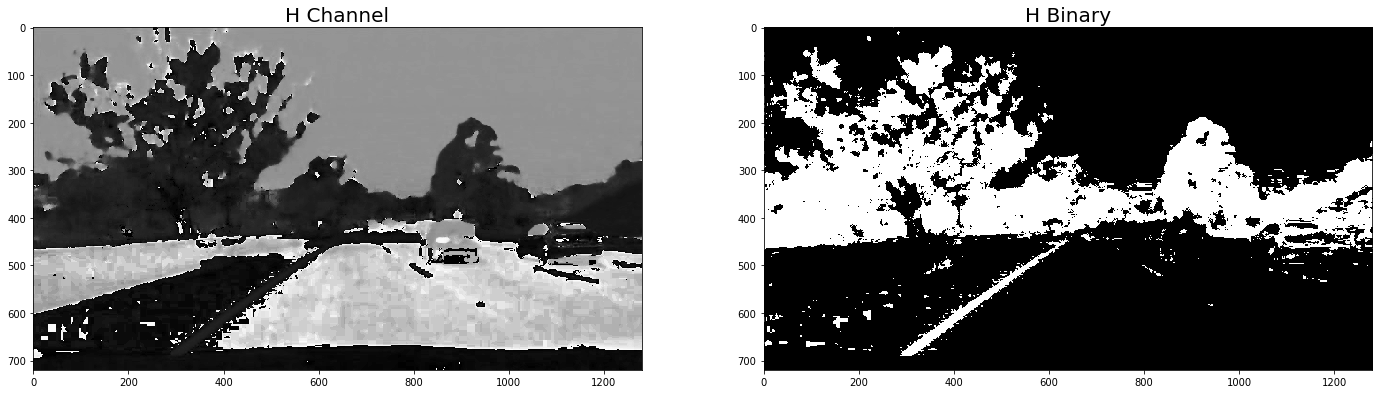

In [12]:
def demo_h_binary(image, thresh = (15, 100)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    
    binary = np.zeros_like(H)
    binary[(H > thresh[0]) & (H <= thresh[1])] = 1
    
    f, axis = plt.subplots(1, 2, figsize=(24, 9))
    axis = axis.ravel()
    
    for i, (title, image) in zip(range(0, 2), zip(['H Channel', 'H Binary'], [H, binary])):
        axis[i].imshow(image, cmap='gray')
        axis[i].set_title(title, fontsize=20)
    plt.show()
    
demo_h_binary(image)

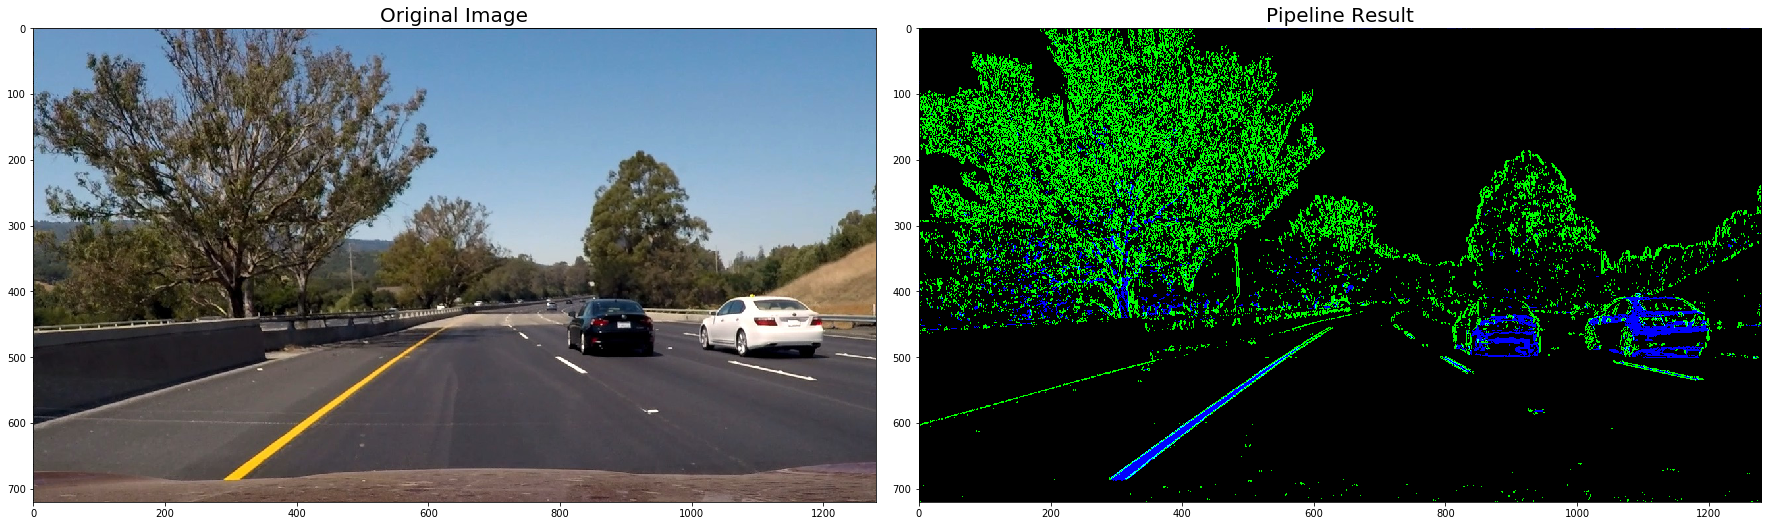

In [13]:
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return color_binary

result = pipeline(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [14]:
def warper(image, src, dst):
    h, w = image.shape[:2]
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(image, M, (w,h), flags=cv2.INTER_LINEAR)
    
    return warped, M, Minv

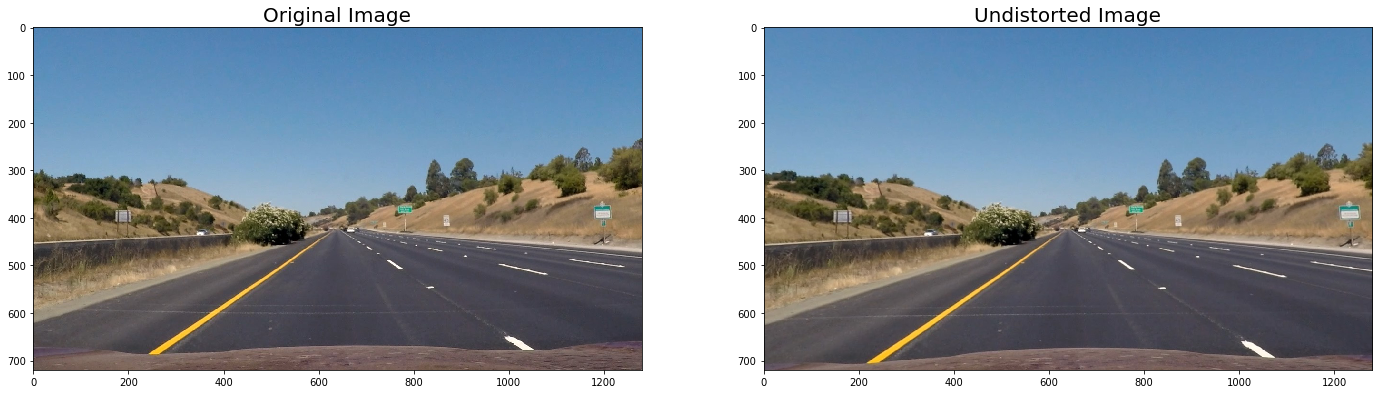

In [15]:
demo_undistort('../test_images/straight_lines1.jpg', mtx, dist)

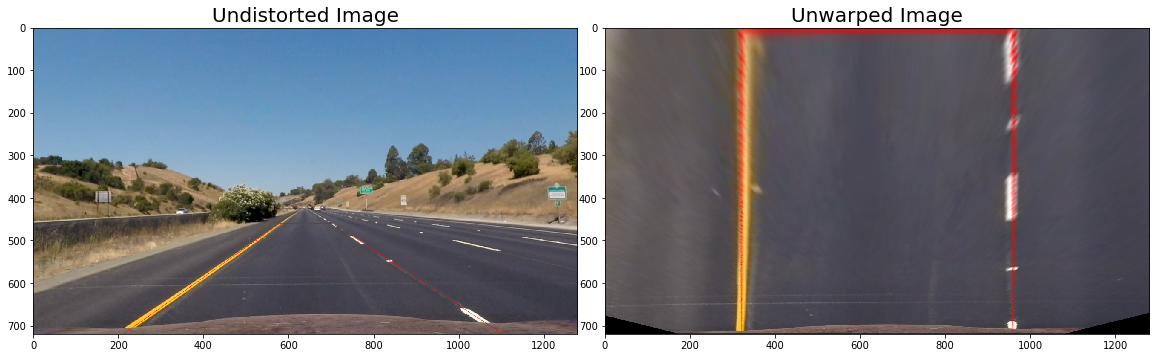

In [47]:
img = mtimage.imread('../test_images/straight_lines1.jpg')

h,w = img.shape[:2]
img_size = (w, h)

src = np.float32(
 [[(w/2) - 60, h/2 + 100],
 [((w/6) - 10), h + 5],
 [(w * 5/6) + 50, h + 5],
 [(w/2 + 62), h/2 + 100]])

dst = np.float32(
 [[(w/4), 0],
 [(w/4), h],
 [(w * 3/4), h],
 [(w * 3/4), 0]])

corners = [tuple(p) for p in src]
cv2.line(img, corners[0], corners[1], color=[255,0,0], thickness=1)
cv2.line(img, corners[1], corners[2], color=[255,0,0], thickness=1)
cv2.line(img, corners[2], corners[3], color=[255,0,0], thickness=1)
cv2.line(img, corners[3], corners[0], color=[255,0,0], thickness=1)

undistorted = undistort(img, mtx, dist)
unwarped, M, Minv = warper(undistorted, src, dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)

ax1.imshow(undistorted)
ax1.set_title('Undistorted Image', fontsize=20)

ax2.imshow(unwarped)
ax2.set_title('Unwarped Image', fontsize=20)
plt.show()

In [ ]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
  
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    grad_binary = np.zeros_like(scaled_sobel)

    # 6) Return this mask as your binary_output image
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx= cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely= cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    grad_mag = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(grad_mag)/255
    scaled_sobel = (grad_mag/scale_factor).astype(np.uint8) 
    # 5) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1

    # 6) Return this mask as your binary_output image    
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction

    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.sqrt(sobelx ** 2)
    abs_sobely = np.sqrt(sobely ** 2)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(grad_dir)
    # 6) Return this mask as your binary_output image
    dir_binary[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1

    return dir_binary

In [ ]:
# Choose a Sobel kernel size
ksize = 5 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(30, 150))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(30, 150))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 200))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.5, 1.3))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
binary = 255*np.dstack((combined,combined,combined)).astype('uint8')  

plt.imshow(combined, cmap='gray')
plt.show()